In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import easyocr
import pytesseract
import mediapipe as mp
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import argparse
from typing import Tuple, Union
import math
import os

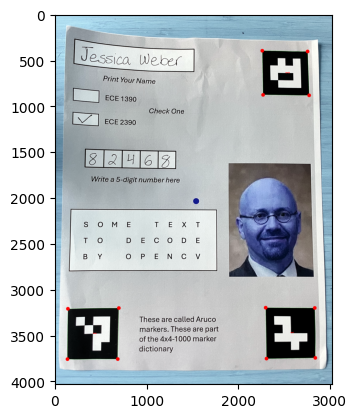

In [2]:
from cv2 import aruco
from packaging import version

imgS = cv2.imread('Homework8.jpg')
img = cv2.imread('Homework8_Fill.jpg')

grayS = cv2.cvtColor(imgS,cv2.COLOR_BGR2GRAY)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

if version.parse(cv2.__version__) >= version.parse("4.7.0"):
    dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_1000)
    detectorParams = cv2.aruco.DetectorParameters()
    detector = cv2.aruco.ArucoDetector(dictionary, detectorParams)
    cornersS, idsS, rejectedS = detector.detectMarkers(imgS)
else:
    dictionary = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_1000)
    detectorParams = cv2.aruco.DetectorParameters_create()
    cornersS, idsS, rejectedS = cv2.aruco.detectMarkers(
        imgS, dictionary, parameters=detectorParams
    )

if version.parse(cv2.__version__) >= version.parse("4.7.0"):
    dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_1000)
    detectorParams = cv2.aruco.DetectorParameters()
    detector = cv2.aruco.ArucoDetector(dictionary, detectorParams)
    corners, ids, rejected = detector.detectMarkers(img)
else:
    dictionary = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_1000)
    detectorParams = cv2.aruco.DetectorParameters_create()
    corners, ids, rejected = cv2.aruco.detectMarkers(
        img, dictionary, parameters=detectorParams
    )

cv2.aruco.drawDetectedMarkers(img,corners,ids)

if corners:
    for marker_corners in corners:
        for corner in marker_corners[0]:
            x,y = int(corner[0]),int(corner[1])
            img = cv2.circle(img,(x,y),20,(255,0,0),-1)

plt.imshow(img)

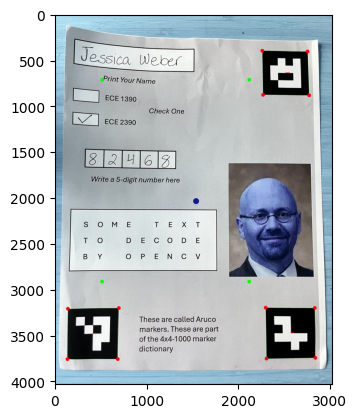

In [3]:

red_dotX,red_dotY = img.shape[1]//2, img.shape[0]//2
lower_left = np.array([6 * 100 + img.shape[1] // 2, -13 * 100 + img.shape[0 ]// 2],dtype=np.float32)
upper_right = np.array([-10 * 100 + img.shape[1] // 2, 9 * 100 + img.shape[0] // 2],dtype=np.float32)
lower_right = np.array([6 * 100 + img.shape[1] // 2, 9 * 100 + img.shape[0] // 2],dtype=np.float32)

upper_left = upper_right - (lower_right - lower_left)

dst_pts = np.array([lower_left,lower_right,upper_right,upper_left],dtype=np.float32)

for point in dst_pts:
    center = (int(point[0]),int(point[1]))
    cv2.circle(img,center,20,color=(0,255,0),thickness = -1)

plt.imshow(img)

[[412.75, 3484.25], [2561.75, 3476.25], [2507.0, 643.75], [4656.0, 635.75]]
[[2112.  716.]
 [2112. 2916.]
 [ 512. 2916.]
 [ 512.  716.]]


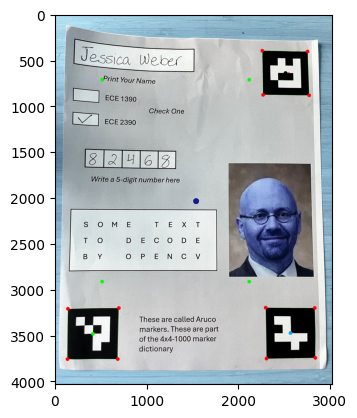

In [4]:
src_pts = []

for marker_id in ids.flatten():
    idx = np.where(ids.flatten() == marker_id)[0]
    if len(idx) > 0:
        marker_corners = corners[idx[0]][0]

        centerX = np.mean(marker_corners[:,0])
        centerY = np.mean(marker_corners[:,1])
        src_pts.append([centerX,centerY])

        colors = [(0,255,0),(0,165,255),(0,0,0)]
        color = colors[idx[0] % len(colors)]
        cv2.circle(img,(int(centerX),int(centerY)),20,color,-1)

if len(src_pts) == 3:

    lower_left = np.array(src_pts[1])
    lower_right = np.array(src_pts[0])
    upper_right = np.array(src_pts[2])

    upper_left = upper_right - (lower_right - lower_left)
    src_pts.append(upper_left.tolist())

    cv2.circle(img,(int(upper_left[0]),int(upper_left[1])),20,(255,0,0),-1)

plt.imshow(img)

print(src_pts)
print(dst_pts)

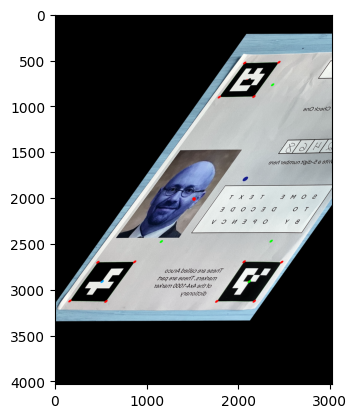

In [5]:
src_pts = np.array(src_pts,dtype=np.float32)
src_pts = src_pts[[2,0,1,3]]
h,w = img.shape[:2]

matrix = cv2.getPerspectiveTransform(src_pts,dst_pts)
aligned_img = cv2.warpPerspective(img,matrix,(w,h))

dst_center = np.mean(dst_pts,axis=0)
aligned_centerX,aligned_centerY = int(dst_center[0]),int(dst_center[1])

shiftX = w // 2 - aligned_centerX
shiftY = h // 2 - aligned_centerY

translationM = np.float32([[1,0,shiftX],[0,1,shiftY]])

centered_img = cv2.warpAffine(aligned_img,translationM,(w,h))

cv2.circle(aligned_img,(aligned_img.shape[1] // 2, aligned_img.shape[0] // 2),20,(255,0,0),-1)
plt.imshow(aligned_img)

In [6]:
def cm_to_pixel(cmX,cmY,centerX,centerY):
    pixelCoordX,pixelCoordY = int(centerX + cmX * 100), int(centerY + cmY*100)

    return pixelCoordX,pixelCoordY


Detected Text: Weber
Detected Text: Jessica


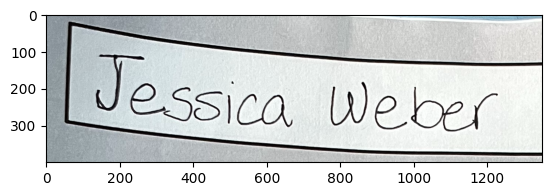

In [7]:
Pixels = 125

img_center = (img.shape[1] // 2, img.shape[0] // 2)

#x,y,w,h = cm_to_pixel(-10-13,*img_center) + (2*Pixels,10*Pixels)

cropped = img[250:650,150:1500]
reader = easyocr.Reader(["en"])
result = reader.readtext(cropped)

for (bbox,text,confidence) in result:
    print(f"Detected Text: {text}")
    plt.imshow(cropped)

Marked Checkbox: ECE-2390


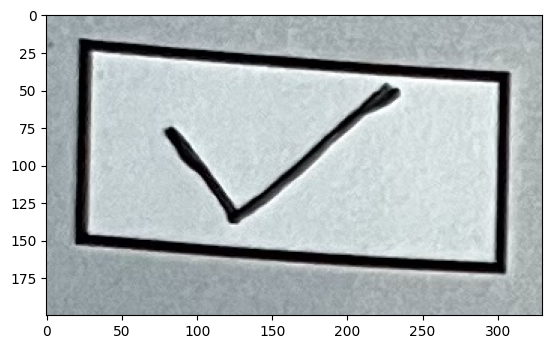

In [8]:
checkbox1 = img[800:975,170:500]
checkbox2 = img[1050:1250,170:500]

intensity1 = np.mean(checkbox1)
intensity2 = np.mean(checkbox2)

marked = "ECE-1390" if intensity1 < intensity2 else "ECE-2390"

plt.imshow(checkbox1)
plt.imshow(checkbox2)
print(f"Marked Checkbox: {marked}")

In [9]:
#pytesseract.pytesseract.tesseract_cmd = r'C:/Users/jessicaweber/github-classroom/SSOE-ECE1390/tesseract-5.5.0'
    
numbersImg = img[1450:1700,300:1350]

#numbers_gray = cv2.cvtColor(numbersImg,cv2.COLOR_BGR2GRAY)

#blur = cv2.GaussianBlur(numbers_gray,(3,3),0)
#blur2 = cv2.GaussianBlur(numbers_gray,(9,9),0)

#sharp_img = cv2.addWeighted(blur,1.5,blur2,-0.5,0)
#_,binary_img = cv2.threshold(sharp_img,0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)

#processed_img = [blur,binary_img,sharp_img,blur2]

#all_results = []

reader = easyocr.Reader(["en"])
result = reader.readtext(numbersImg,allowlist='0123456789')

#if True:
    #config = '--psm 10 -c tessedit_char_whitelist=0123456789'
#else:
    #config = '--psm 6'

#for image in processed_img:
    #results = text_confidence(img,config)
    #for text, confidence in results:
        #all_results.append((text,confidence))

#best_result = max(all_results,key=lambda x:x[1])

def read_numbers(img):

    result  = reader.readtext(img,allowlist='0123456789')

    numbers = []

    for detection in result:
        text = detection[1]
        try:
            number = float(text)
            numbers.append(number)

        except ValueError:
            pass

    return numbers

numbers = read_numbers(numbersImg)
print(numbers)



[2.0]


Detected Text: S   0 M E
Detected Text: T E X T
Detected Text: T   0
Detected Text: D E C 0 D E
Detected Text: B   Y
Detected Text: 0 P E N C V


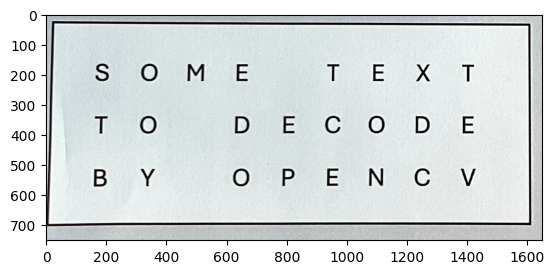

In [10]:
text_box = img[2100:2850,150:1800]

#rgb = cv2.cvtColor(text_box,cv2.COLOR_BGR2RGB)
#gray = cv2.cvtColor(text_box,cv2.COLOR_BGR2GRAY)

#_,binary_img = cv2.threshold(gray,0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#h,w = rgb.shape[:2]

#center = (w//2,h//2)

#rotationM = cv2.getRotationMatrix2D(center,angle,1.0)
#rotated_img = cv2.warpAffine(text_box,rotationM,(w,h))

#results = pytesseract.image_to_data(rotated_img,output_type=pytesseract.Output.DICT, config=config)

reader = easyocr.Reader(['en'])
result = reader.readtext(text_box)

#for i in range(len(results["text"])):
    #x,y,w,h = results["left"][i],results["top"][i],results["width"][i],results["height"][i]
    #text = results["text"][i]
    #conf = int(results["conf"][i])

    #if conf > 0:
        #print(f"Confidence: {conf}")
        #print(f"Text: {text}")

for (bbox,text,confidence) in result:
    print(f"Detected Text: {text}")
    plt.imshow(text_box)

I tried my very best to properly install pytesseract but after a lot of dead ends I 
completed the rest of the assignment with easyocr. It performed very well with the
text but not well with the handwritten numbers. I attempted some code using pytesseract that is commented out but was never able to actually test it

I0000 00:00:1733257999.451915 2216221 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1733257999.454056 2216481 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733257999.460185 2216478 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733257999.462582 2216480 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


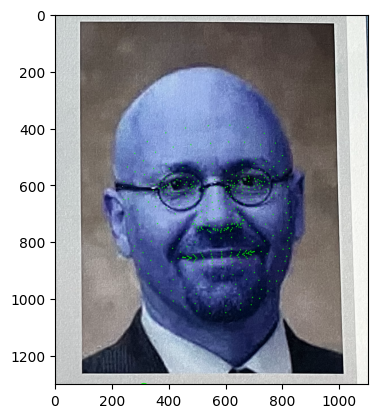

In [12]:
face = img[1600:2900,1800:2900]

mp_face_det = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True,max_num_faces=1,refine_landmarks=True)

rgb = cv2.cvtColor(face,cv2.COLOR_BGR2RGB)

results = face_mesh.process(rgb)

if results.multi_face_landmarks:
    for face_landmarks in results.multi_face_landmarks:
        for id, landmark in enumerate(face_landmarks.landmark):
            h,w = int(2900-1600),int(2900-1800)
            x,y = int(landmark.x*w),int(landmark.y*h)
            cv2.circle(face,(x,y),2,(0,255,0),-1)

plt.imshow(face)
